In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from matplotlib.patches import Patch

%matplotlib inline

In [4]:
# Importing the groundwater measurement data in Pickle format
df_ms_ws_input = pd.read_pickle("../data/processed/grundwasserdaten-NRW/GW-MessWasserstellenMerge.pkl")
df_ms_total_trend_gis = pd.read_pickle("../data/processed/grundwasserdaten-NRW/GW-MessstellenTotalTrendGIS.pkl")

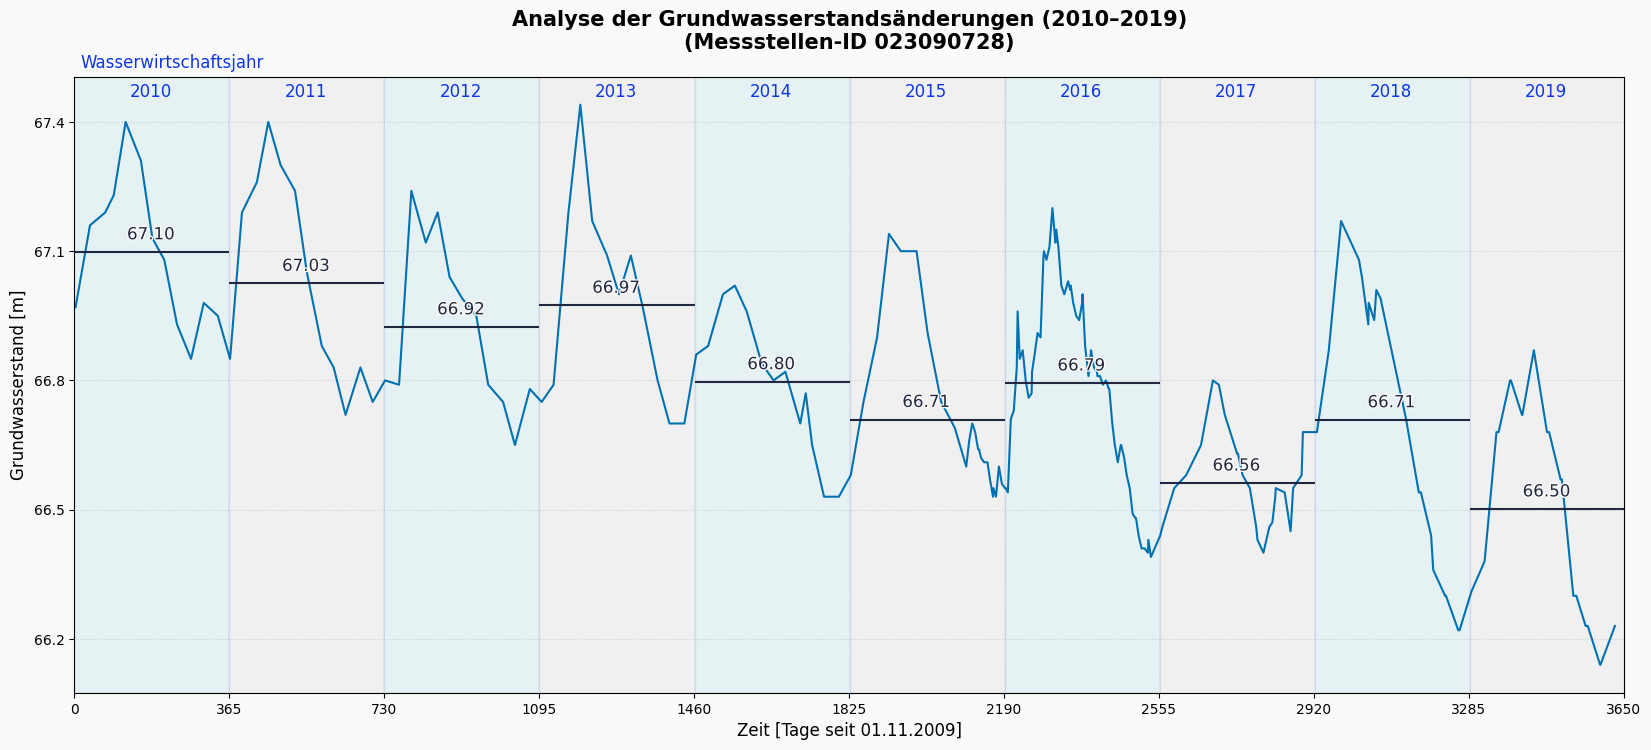

In [ ]:
# Startdatum
tage_pro_jahr = 365.25 # Mit Schaltjahr
startjahr = 2010 # Kalendarisches Datum
t0 = pd.Timestamp("2009-11-01") # Beginn des Wasserwirtschaftsjahr 2010

visualized_ms = '023090728'

df_relevant_ms = (
        df_ms_ws_input
        .loc[df_ms_ws_input.loc[:, 'messstelle_id'] == visualized_ms]
        .sort_values('datum_messung')
        .copy()
        )

df_relevant_ms_total_trend = (
        df_ms_total_trend_gis
        .loc[df_ms_total_trend_gis.loc[:, 'messstelle_id'] == visualized_ms]
        .copy()
        )

df_relevant_ms["t"] = (df_relevant_ms["datum_messung"] - t0).dt.days

# Plotten zu visualisierenden Grundwasserstände
fig, ax = plt.subplots(figsize=[20, 8], nrows=1, ncols=1)

# Darstellung der Grundwaser-Ganglinie
df_relevant_ms.plot(kind='line', x='t', y='wasserstd_m', ax=ax, legend=False, color='#0072B2')

ax.set_title(f"Analyse der Grundwasserstandsänderungen (2010–2019)\n(Messstellen-ID {visualized_ms})",
             fontsize=15, fontweight="bold", color="black", pad=20)
ax.set_xlabel(f"Zeit [Tage seit {t0.strftime("%d.%m.%Y]")}", fontsize=12)
ax.set_ylabel("Grundwasserstand [m]", fontsize=12)
ax.set_xticks([jahr * 365 for jahr in range(11)])
ax.set_yticks([66.2, 66.5, 66.8, 67.1 , 67.4])
ax.set_yticklabels(['66.2', '66.5', '66.8', '67.1', '67.4'], rotation=0)
ax.set_xlim(0, 3651)
ax.grid(True, linestyle=':', alpha=0.5, axis='y')

ax.text(x=15, y=67.525, s='Wasserwirtschaftsjahr', fontsize=12, color="#002AE6F0")


# Darstellung der Wasserwirtschaftsjahre
for jahr in range(10):  
    start = jahr * tage_pro_jahr
    ende = (jahr + 1) * tage_pro_jahr

    ax.text(
        x = start + 180,                          # x-Position
        y = 67.45,                          # y-Position (oben)
        s = str(startjahr + jahr),          # Text
        ha="center", va="bottom",           # horizontale/vertikale Ausrichtung
        fontsize=12, color="#002AE6F0"
    )
    # farbige Hintergrundflächen
    ax.axvspan(start, ende, 
                  color=("lightblue" if jahr % 2 == 0 else "lightgray"),
                  alpha=0.25)
    # Darstellung der durchschnittlichen Grundwasserstände pro Jahr
    ax.hlines(
        y = float(df_relevant_ms_total_trend.iloc[0, jahr + 9]),
        xmin = start,
        xmax = ende,
        color = "#141A33EF"
        )
    ax.text(
        x = start + 180,
        y = float(df_relevant_ms_total_trend.iloc[0, jahr + 9] + 0.02),
        s = format(float(df_relevant_ms_total_trend.iloc[0, jahr + 9]), ".2f"),
        ha="center", va="bottom",   
        fontsize=12, color="#141A33EF",
        path_effects=[path_effects.Stroke(linewidth=2, foreground='#FAFAFA'), path_effects.Normal()],
        )

# Darstellung der Wasserwirtschaftsjahre
for jahr in range(11):   # 10 Jahre = 11 Marken
    x_pos = jahr * tage_pro_jahr
    ax.axvline(x=x_pos, color="blue", linestyle=":", alpha=0.7, linewidth=0.2)

# Hintergrundfarben
ax.set_facecolor('#FAFAFA')
fig.patch.set_facecolor('#FAFAFA')


In [6]:
fig.savefig("../pictures/05_visual_total_trend_2010-2019_1.png", dpi=300, bbox_inches="tight")

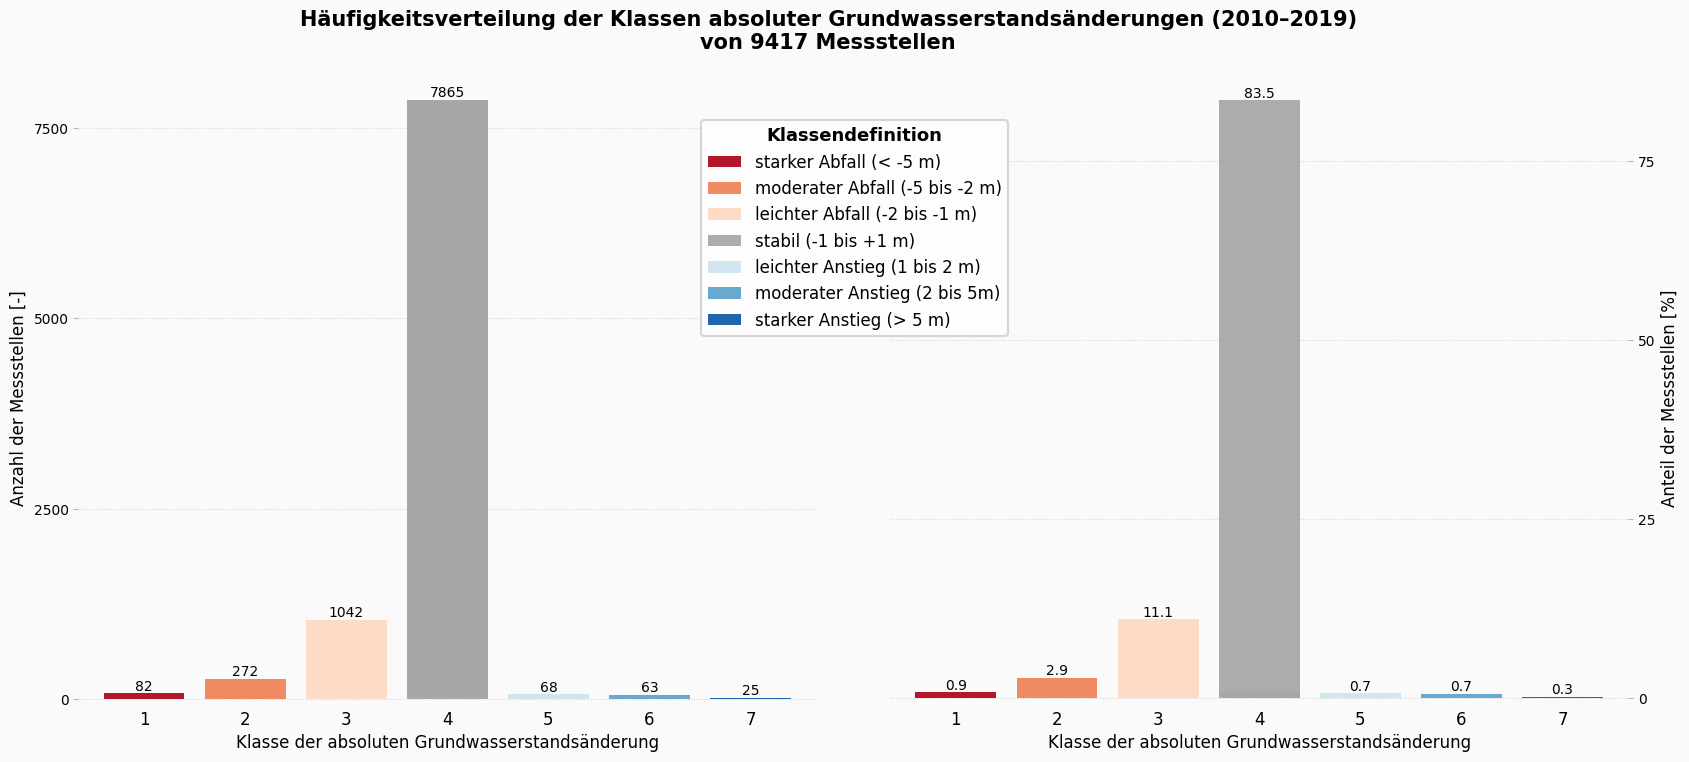

In [ ]:

farbklassen = {
    1: {"farbe": "#b2182b", "label": "starker Abfall (< -5 m)"},
    2: {"farbe": "#ef8a62", "label": "moderater Abfall (-5 bis -2 m)"},
    3: {"farbe": "#fddbc7", "label": "leichter Abfall (-2 bis -1 m)"},
    4: {"farbe": "#a7a7a7ef", "label": "stabil (-1 bis +1 m)"},
    5: {"farbe": "#d1e5f0", "label": "leichter Anstieg (1 bis 2 m)"},
    6: {"farbe": "#67a9cf", "label": "moderater Anstieg (2 bis 5m)"},
    7: {"farbe": "#2166ac", "label": "starker Anstieg (> 5 m)"},
}

abs_counts = (
    df_ms_total_trend_gis.loc[:, "trend_2019-2010_class"]
    .astype("Int64")
    .value_counts()
    .reindex(farbklassen.keys(), fill_value=0)
)

rel_counts = (
    df_ms_total_trend_gis.loc[:, "trend_2019-2010_class"]
    .astype("Int64")
    .value_counts(normalize=True)
    .reindex(farbklassen.keys(), fill_value=0)
)

farben_liste = [farbklassen[k]["farbe"] for k in abs_counts.index]

# Plotten zu visualisierenden Grundwasserpegel
fig, ax = plt.subplots(figsize=[20, 8], nrows=1, ncols=2)

df_ms_total_trend_gis.loc[:,'trend_2019-2010_class'].value_counts(normalize=False).sort_index().plot(kind='bar', ax=ax[0], color=farben_liste, width = 0.8)
df_ms_total_trend_gis.loc[:,'trend_2019-2010_class'].value_counts(normalize=True).sort_index().mul(100).plot(kind='bar', ax=ax[1], color=farben_liste, width = 0.8)

# Beschriftung der einzelnen Balken
for bar in ax[0].bar(range(len(abs_counts)), abs_counts, color=farben_liste):
    h = bar.get_height() 
    ax[0].text(
        bar.get_x() + bar.get_width() / 2,
        h,
        f"{int(h)}",
        ha="center",
        va="bottom"
    )
for bar in ax[1].bar(range(len(rel_counts)), rel_counts, color=farben_liste):
    h = bar.get_height()
    ax[1].text(
        bar.get_x() + bar.get_width() / 2,
        h * 100,
        f"{(h * 100):.1f}",
        ha="center",
        va="bottom"
    )

ax[1].yaxis.set_ticks_position('right')
ax[1].yaxis.tick_right()
ax[1].tick_params(axis="y", labelleft=False, labelright=True)
ax[1].yaxis.set_label_position("right")

for axes in range(2):
    ax[axes].grid(True, linestyle=':', alpha=0.5, axis='y')
    ax[axes].set_axisbelow(True)
    ax[axes].set_xlabel('Klasse der absoluten Grundwasserstandsänderung', fontsize=12)
    ax[axes].set_xticklabels(['1', '2', '3', '4', '5', '6', '7'], rotation=0, fontsize= 12)
    ax[axes].tick_params(axis='y', colors="#B6B6B6", labelcolor='black')
    
    if axes == 0:
        ax[axes].set(ylim=[-80, 8000])
        ax[axes].set_yticks([0, 2500, 5000, 7500])
        ax[axes].set_yticklabels(['0', '2500', '5000', '7500'], rotation=0)
        ax[axes].set_ylabel('Anzahl der Messstellen [-]', fontsize=12)
    if axes == 1:
        ax[axes].set(ylim=[-1, 85])
        ax[axes].set_yticks([0, 25, 50, 75])
        ax[axes].set_yticklabels(['0', '25', '50', '75'], rotation=0)
        ax[axes].set_ylabel('Anteil der Messstellen [%]', fontsize=12)
    
    ax[axes].set_facecolor('#FAFAFA')

    for spine in ax[axes].spines.values(): # Ausblenden der Umrahmung der Achsen
        spine.set_visible(False)
    ax[axes].tick_params(axis="x", which="both", length=0)


# Legende
ax[1].set_zorder(ax[0].get_zorder() - 1)

handles = [
        Patch(
            facecolor=patch.get_facecolor(),
            label=farbklassen[i]['label']
        )
        for i, patch in zip(abs_counts.index, ax[0].patches)
        ]

leg = ax[0].legend(
        frameon=True,
        handles=handles,
        title="Klassendefinition",
        loc="upper right",
        fontsize=12,
        bbox_to_anchor=(1.26, 0.95),
        borderaxespad=0
    )

leg.get_frame().set_linewidth(1.5)
leg.get_title().set_fontsize(13)
leg.get_title().set_fontweight("bold")
leg.set_zorder(100)

# Hintergrundfarben
fig.tight_layout
fig.subplots_adjust(wspace=0.1)
fig.suptitle(f'Häufigkeitsverteilung der Klassen absoluter Grundwasserstandsänderungen (2010–2019)\nvon {abs_counts.sum()} Messstellen', fontsize=15, fontweight="bold")
fig.patch.set_facecolor('#FAFAFA')

In [8]:
fig.savefig("../pictures/05_visual_total_trend_2010-2019_2.png", dpi=300, bbox_inches="tight")